# Mass-Spring-Damper System: Postprocessing the FNN for the Trunk

In [1]:
### Importing Libraries

import sys
print(sys.version)
import os
import time


### Defining WORKSPACE_PATH

# WORKSPACE_PATH = os.environ['WORKSPACE_PATH']
WORKSPACE_PATH = os.path.join(os.getcwd(), '../../../../../../../')
ROMNet_fld     = os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/')

### Importing External Libraries

import numpy                             as np
import pandas                            as pd


### Importing Matplotlib and Its Style

import matplotlib.pyplot                 as plt

#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/presentation.mplstyle'))
plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/zoomed.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_1column.mplstyle'))
#plt.style.use(os.path.join(WORKSPACE_PATH, 'ROMNet/romnet/extra/postprocessing/paper_2columns.mplstyle'))


# from scipy.integrate import solve_ivp
# import pyDOE
# from PCAfold         import PCA          as PCAA


import romnet                            as rmnt

3.8.11 (default, Jun 29 2021, 03:17:05) 
[Clang 12.0.0 (clang-1200.0.32.29)]


Missing colon in file PosixPath('/Users/sventur/.matplotlib/stylelib/paper_2columns.mplstyle'), line 1 ('f#### MATPLOTLIBRC FORMAT')


## Defining Input Variables

In [2]:
#PCAType         = 'All'

PCAType         = 'OneByOne'
i_red           = 1


if (PCAType == 'OneByOne'):
    #path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_100Cases_PCA_'+str(i_red)+'_Trunk/FNN/TestCase3/')
    path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_100Cases_PCA_'+str(i_red)+'_Trunk/FNN/Run_2/')
elif (PCAType == 'All'):
    path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_100Cases_PCA_All_Trunk/FNN/TestCase4/')
    #path_to_run_fld = os.path.join(WORKSPACE_PATH, 'ROMNet/MSD_100Cases_PCA_All_Trunk/FNN/Run_1/')

FigDir          = None #os.path.join(WORKSPACE_PATH, '../Desktop/Paper_Figures_DeepONet_TEMP/')


TrainingCases   = [0]#[0,2,4,6,8]
TestCases       = [0,2,4]#[0,2]

NSamples        = 100

Nt              = 100
tout            = np.linspace(0.,15.,Nt)
SOLVER          = 'Radau'


LineVec         = ['-',':','--','.-']*10
ColorVec        = ['#190707', '#dd3232', '#0065a9', '#348a00','#985396','#f68b69']

## Loading ROMNet's Input Data File

In [3]:
print("\n[ROMNet]: Reading Input File from: ", path_to_run_fld)
sys.path.insert(0, path_to_run_fld)

print("\n[ROMNet]: Keep Loading Modules and Functions...")
from ROMNet_Input import inputdata

print("\n[ROMNet]: Initializing Input ...")
InputData                 = inputdata(WORKSPACE_PATH)


InputData.InputFilePath   = path_to_run_fld+'/ROMNet_Input.py'
InputData.train_int_flg   = 0
InputData.path_to_run_fld = path_to_run_fld


[ROMNet]: Reading Input File from:  /Users/sventur/WORKSPACE/ROMNet/romnet/scripts/postprocessing/PCA/MassSpringDamper/FNN/../../../../../../../ROMNet/MSD_100Cases_PCA_1_Trunk/FNN/Run_2/

[ROMNet]: Keep Loading Modules and Functions...

[ROMNet]: Initializing Input ...


## Loading Tensorflow's Model for the Network 

In [4]:
surrogate_type = InputData.surrogate_type
if (surrogate_type == 'FNN-SourceTerms'):
    surrogate_type = 'FNN'

Net   = getattr(rmnt.nn, surrogate_type)

model = rmnt.model.Model_TF(InputData)

if (InputData.phys_system is not None):
    System = getattr(rmnt.pinn.system, InputData.phys_system)
    system = System(InputData)
    
model.build(InputData, None, Net, system)#, loadfile_no='000027')

NN    = model.net


[ROMNet - model_tf.py    ]:   Initializing the ML Model

[ROMNet - model_tf.py    ]:   Building the ML Model

[ROMNet - fnn.py                    ]:   Constructing Feed-Forward Network: 
[ROMNet - system_of_components.py   ]:     Constructing System of Components: FNN
[ROMNet - component.py              ]:       Constructing Component: FNN
[ROMNet - sub_component.py          ]:         Constructed Sub-Component: Main with Layers:       ListWrapper([<romnet.nn.building_blocks.normalization.CustomNormalization object at 0x1605a72e0>, <keras.layers.core.dense.Dense object at 0x16072f550>, <keras.layers.core.dropout.Dropout object at 0x1607f3be0>, <keras.layers.core.dense.Dense object at 0x1607f3af0>, <keras.layers.core.dropout.Dropout object at 0x1607f30a0>, <keras.layers.core.dense.Dense object at 0x16072f700>, <keras.layers.core.dropout.Dropout object at 0x1607f3070>, <keras.layers.core.dense.Dense object at 0x16070c1c0>])

[ROMNet - model_tf.py    ]:   Loading ML Model Parameters from

## Evaluating Trunk on Test Data

iVar =  0


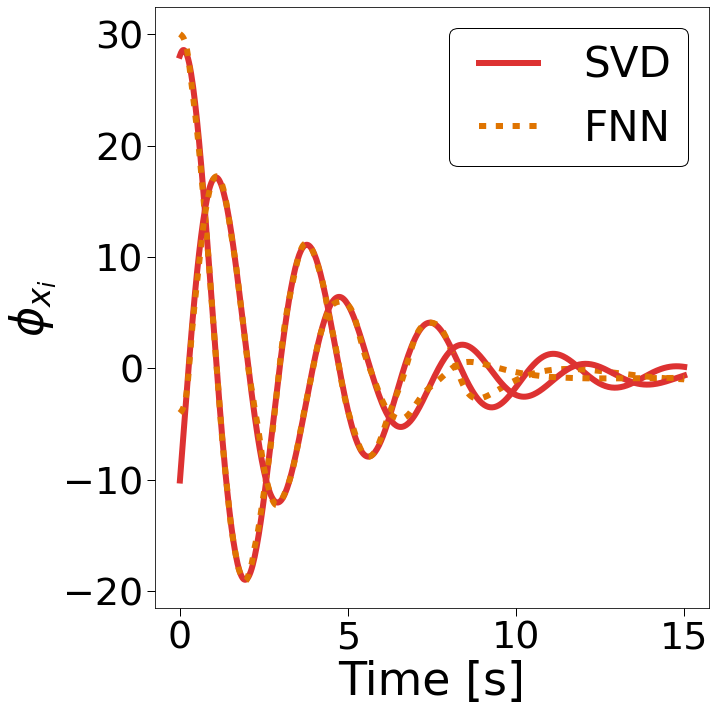

In [5]:
VarOI     = 'PCA_1'

Vars      = ['PCA_'+str(i_mode+1) for i_mode in range(InputData.n_modes)]

FileName  = InputData.path_to_data_fld + '/test/ext/Input.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
tVec      = Data['t'].to_numpy()[...,np.newaxis]
VarNames  = list(Data.columns).remove('t')

FileName  = InputData.path_to_data_fld + '/test/ext/Output.csv'# + InputData.InputFile
Data      = pd.read_csv(FileName, header=0)
Output    = Data[Vars].to_numpy()


## Variable to Be Visualized
for iVar in range(len(Vars)):
    if (Vars[iVar] == VarOI):
        print('iVar = ', iVar)
        break

        
yMat = model.predict(tVec)    

if (PCAType == 'All'):
    Var    = ''
    ColorA = ColorVec[0]
    ColorB = '#848484'
else:
    if (i_red == 1):
        Var    = 'x_'
        ColorA = ColorVec[1]
        ColorB = '#DF7401'
        ColorC = ColorVec[1]
        ColorD = ColorVec[1]
    else:
        Var = 'v_'
        ColorA = ColorVec[0]
        ColorB = '#848484'


fig = plt.figure()

plt.plot(tVec, Output[:,0], '-',   color=ColorA, label='SVD')
plt.plot(tVec, yMat[:,0],     ':', color=ColorB, label='FNN')

plt.plot(tVec, Output[:,1], '-',   color=ColorA)
plt.plot(tVec, yMat[:,1],     ':', color=ColorB)

plt.xlabel('Time [s]')
plt.ylabel(r'$\phi_{'+Var+'i}$')
#plt.ylim([-6.,6.])

plt.legend()

fig.tight_layout()  # otherwise the right y-label is slightly clipped

if (FigDir):
    if (PCAType == 'All'):
        plt.savefig(FigDir+'/MSD_All_Trunk.eps', format='eps', bbox_inches='tight')
    else:
        plt.savefig(FigDir+'/MSD_OneByOne_Trunk_'+str(i_red)+'.eps', format='eps', bbox_inches='tight')

In [6]:
print('[PCA]  Max % Error = ', np.max(abs((yMat - Output)/yMat)*100))
print('[PCA]  Max      SE = ', np.max((yMat - Output)**2))
print('[PCA] Mean % Error = ', np.mean(abs((yMat - Output)/yMat)*100))
print('[PCA]          MSE = ', np.mean((yMat - Output)**2))

[PCA]  Max % Error =  27585.698648294452
[PCA]  Max      SE =  36.77958833853453
[PCA] Mean % Error =  194.335810319445
[PCA]          MSE =  0.6752216415647282


## Plotting Loss Histories

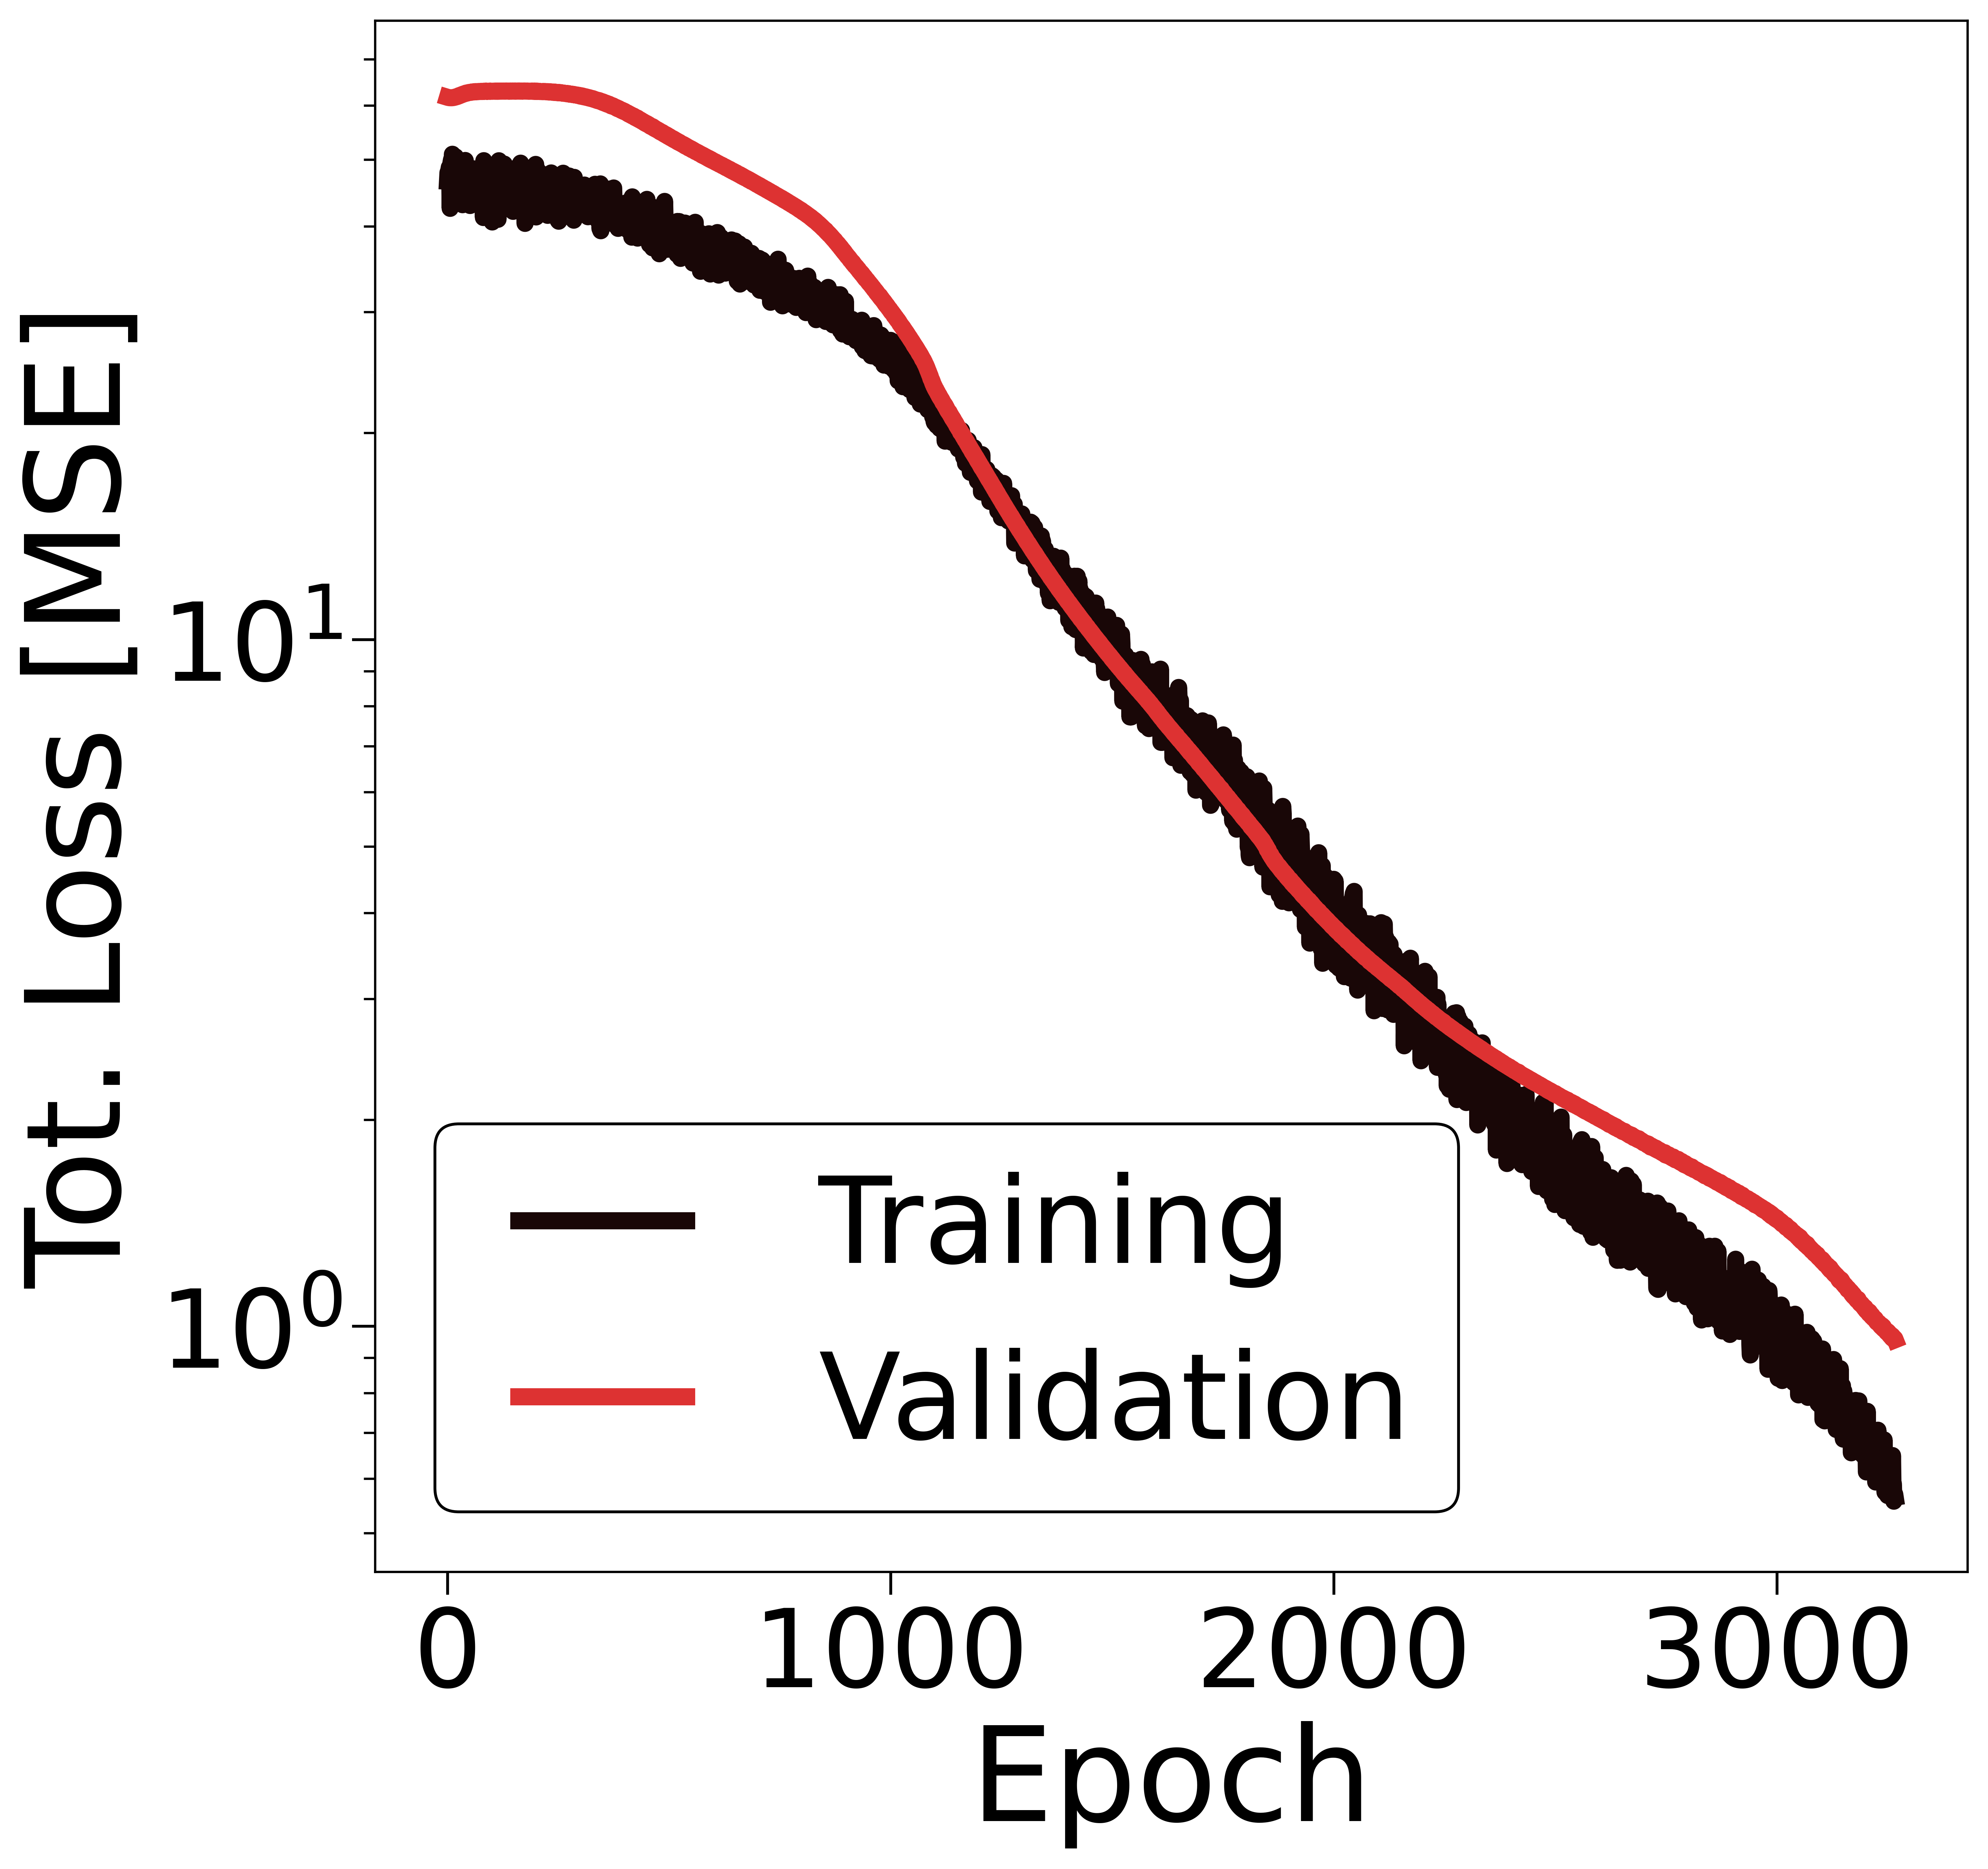

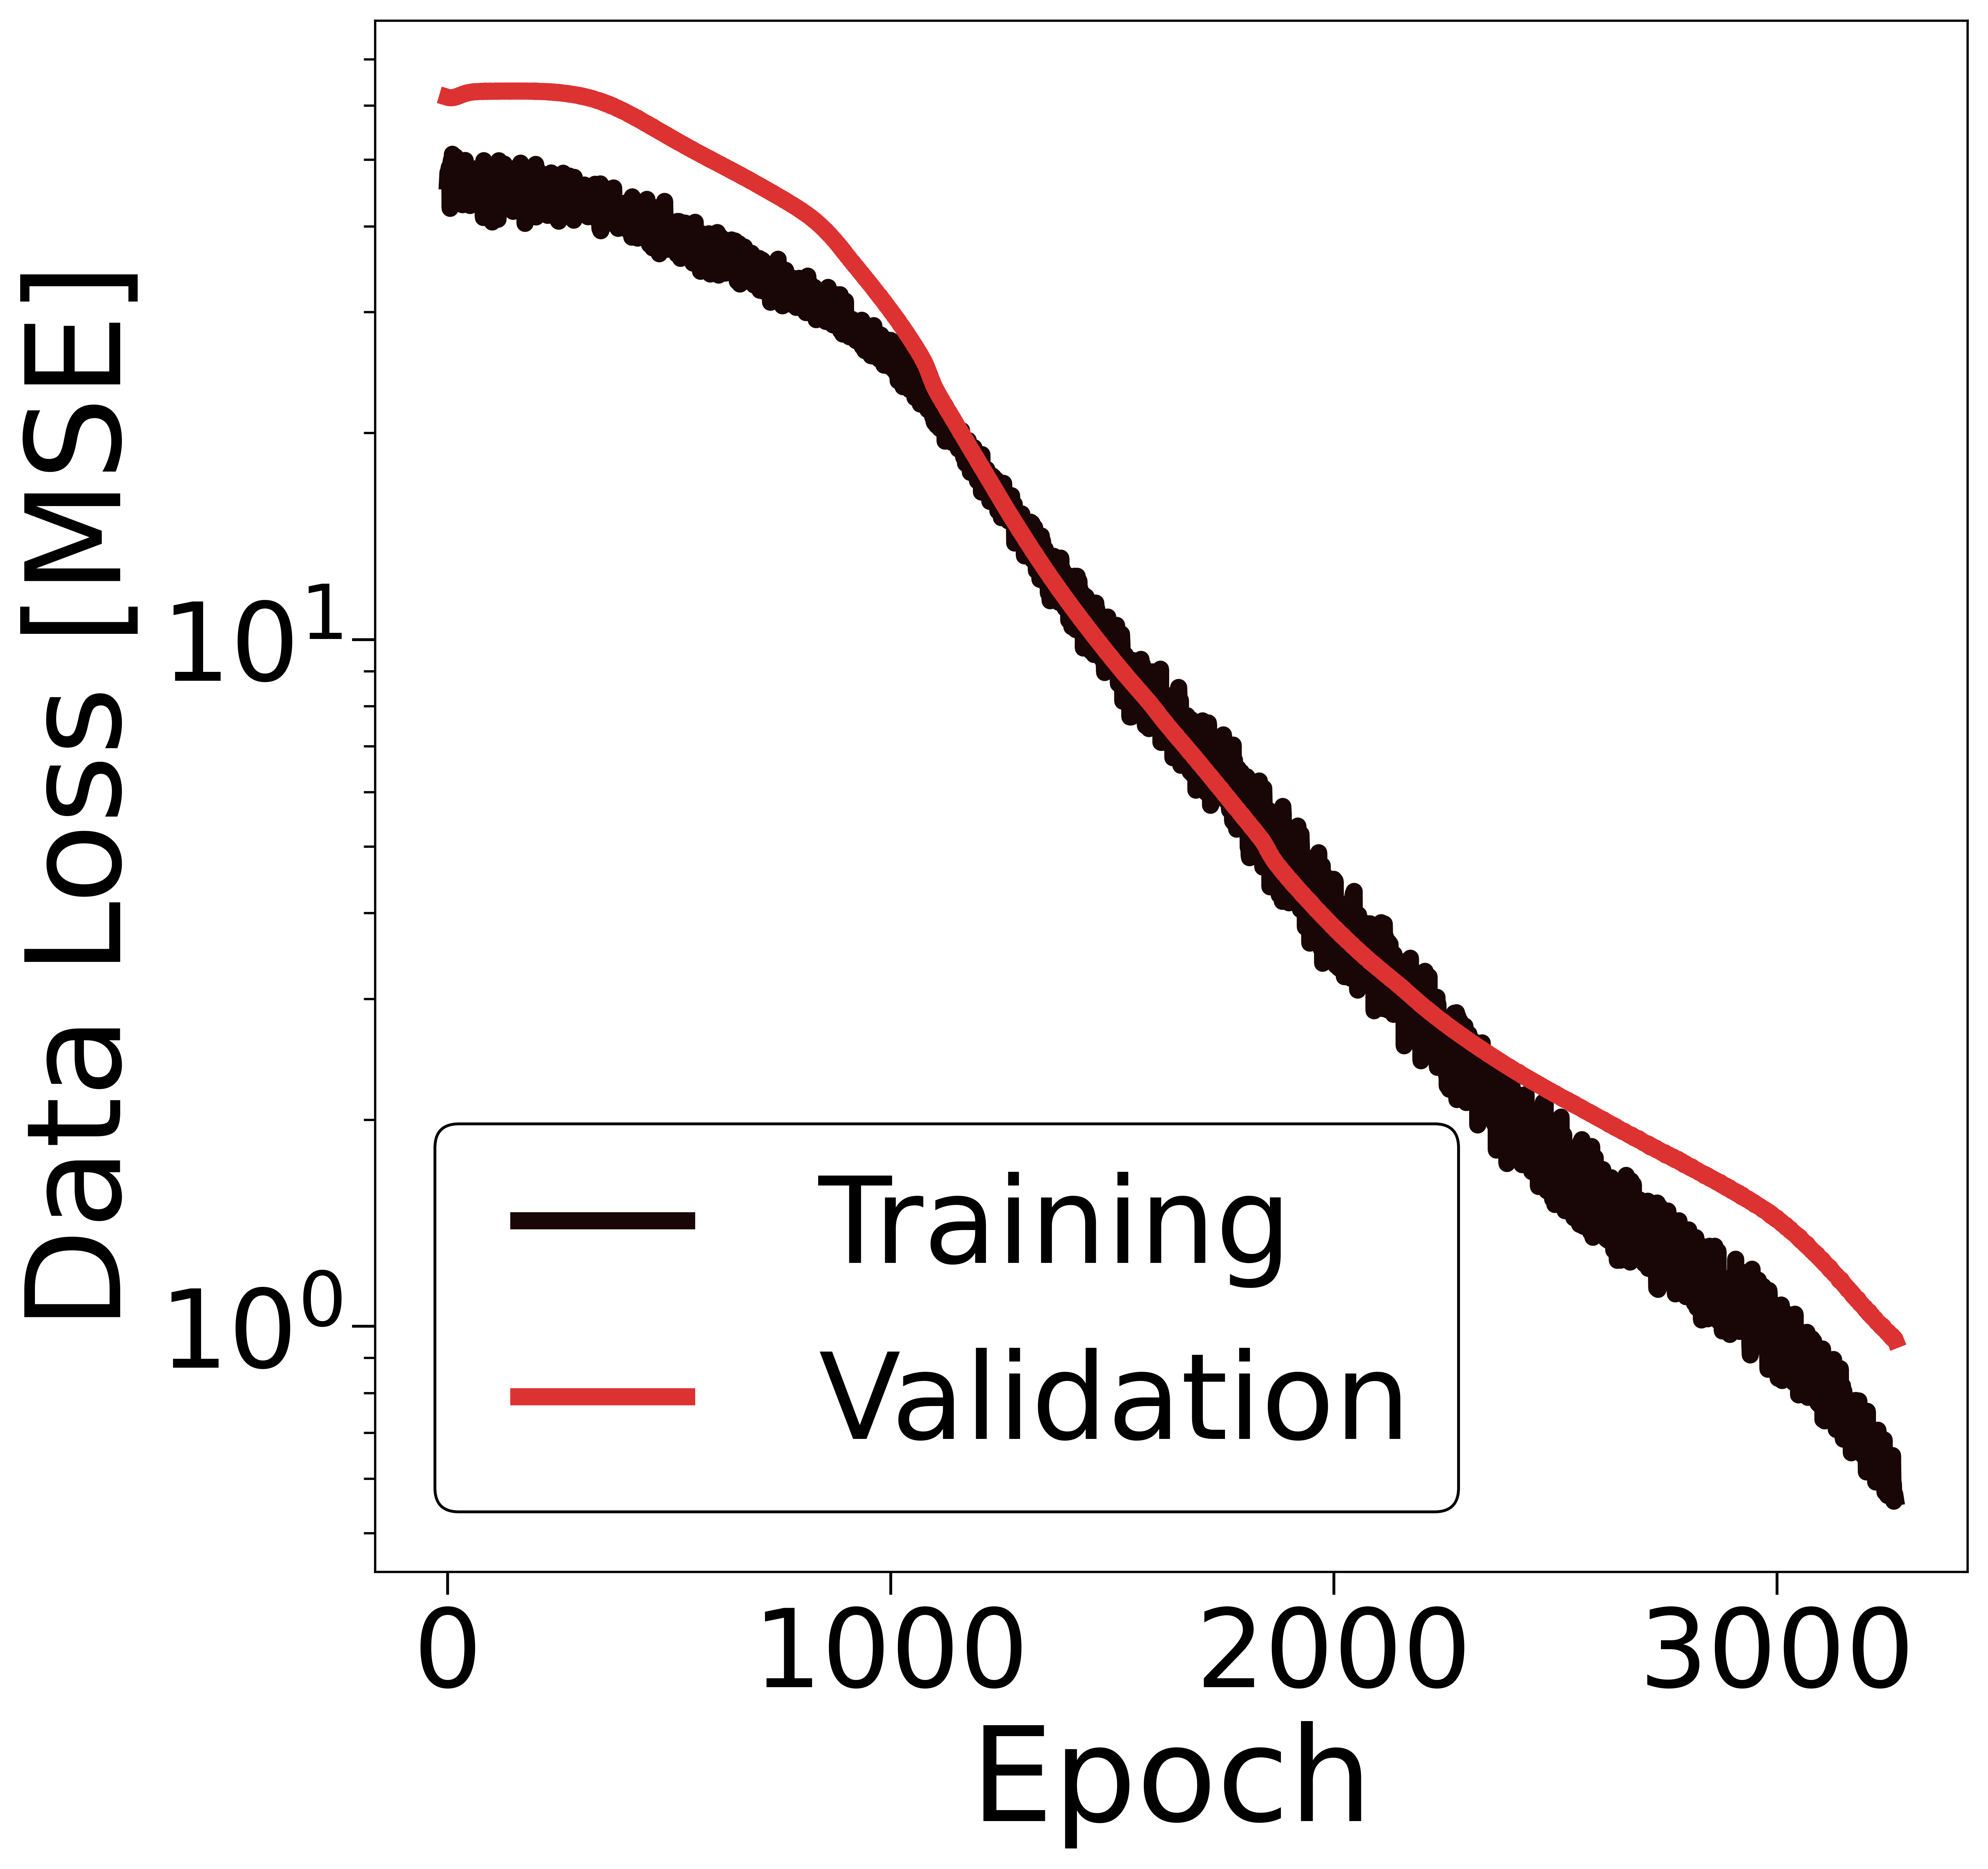

In [7]:
Data = pd.read_csv(path_to_run_fld+'/Training/History.csv')

fig  = plt.figure()
plt.plot(Data['tot_loss'],     label='Training')
plt.plot(Data['val_tot_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Tot. Loss [MSE]')
plt.legend()
plt.yscale('log')

fig  = plt.figure()
plt.plot(Data['pts_loss'],     label='Training')
plt.plot(Data['val_pts_loss'], label='Validation')
plt.xlabel('Epoch')
plt.ylabel('Data Loss [MSE]')
plt.legend()
plt.yscale('log')
#plt.ylim([1.e-2, 1.e0])

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['scs_loss'],     label='Training')
# plt.plot(Data['val_scs_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('S.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

# fig  = plt.figure(figsize=(12,8))
# plt.plot(Data['ics_loss'],     label='Training')
# plt.plot(Data['val_ics_loss'], label='Validation')
# plt.xlabel('Epoch')
# plt.ylabel('I.C.s Loss [MSE]')
# plt.legend()
# plt.yscale('log')

In [8]:
OutputDir = InputData.path_to_data_fld

FileName = OutputDir+'/../ROM/A.csv'
A        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/../ROM/C.csv'
C        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

FileName = OutputDir+'/../ROM/D.csv'
D        = pd.read_csv(FileName, delimiter=',', header=None).to_numpy()

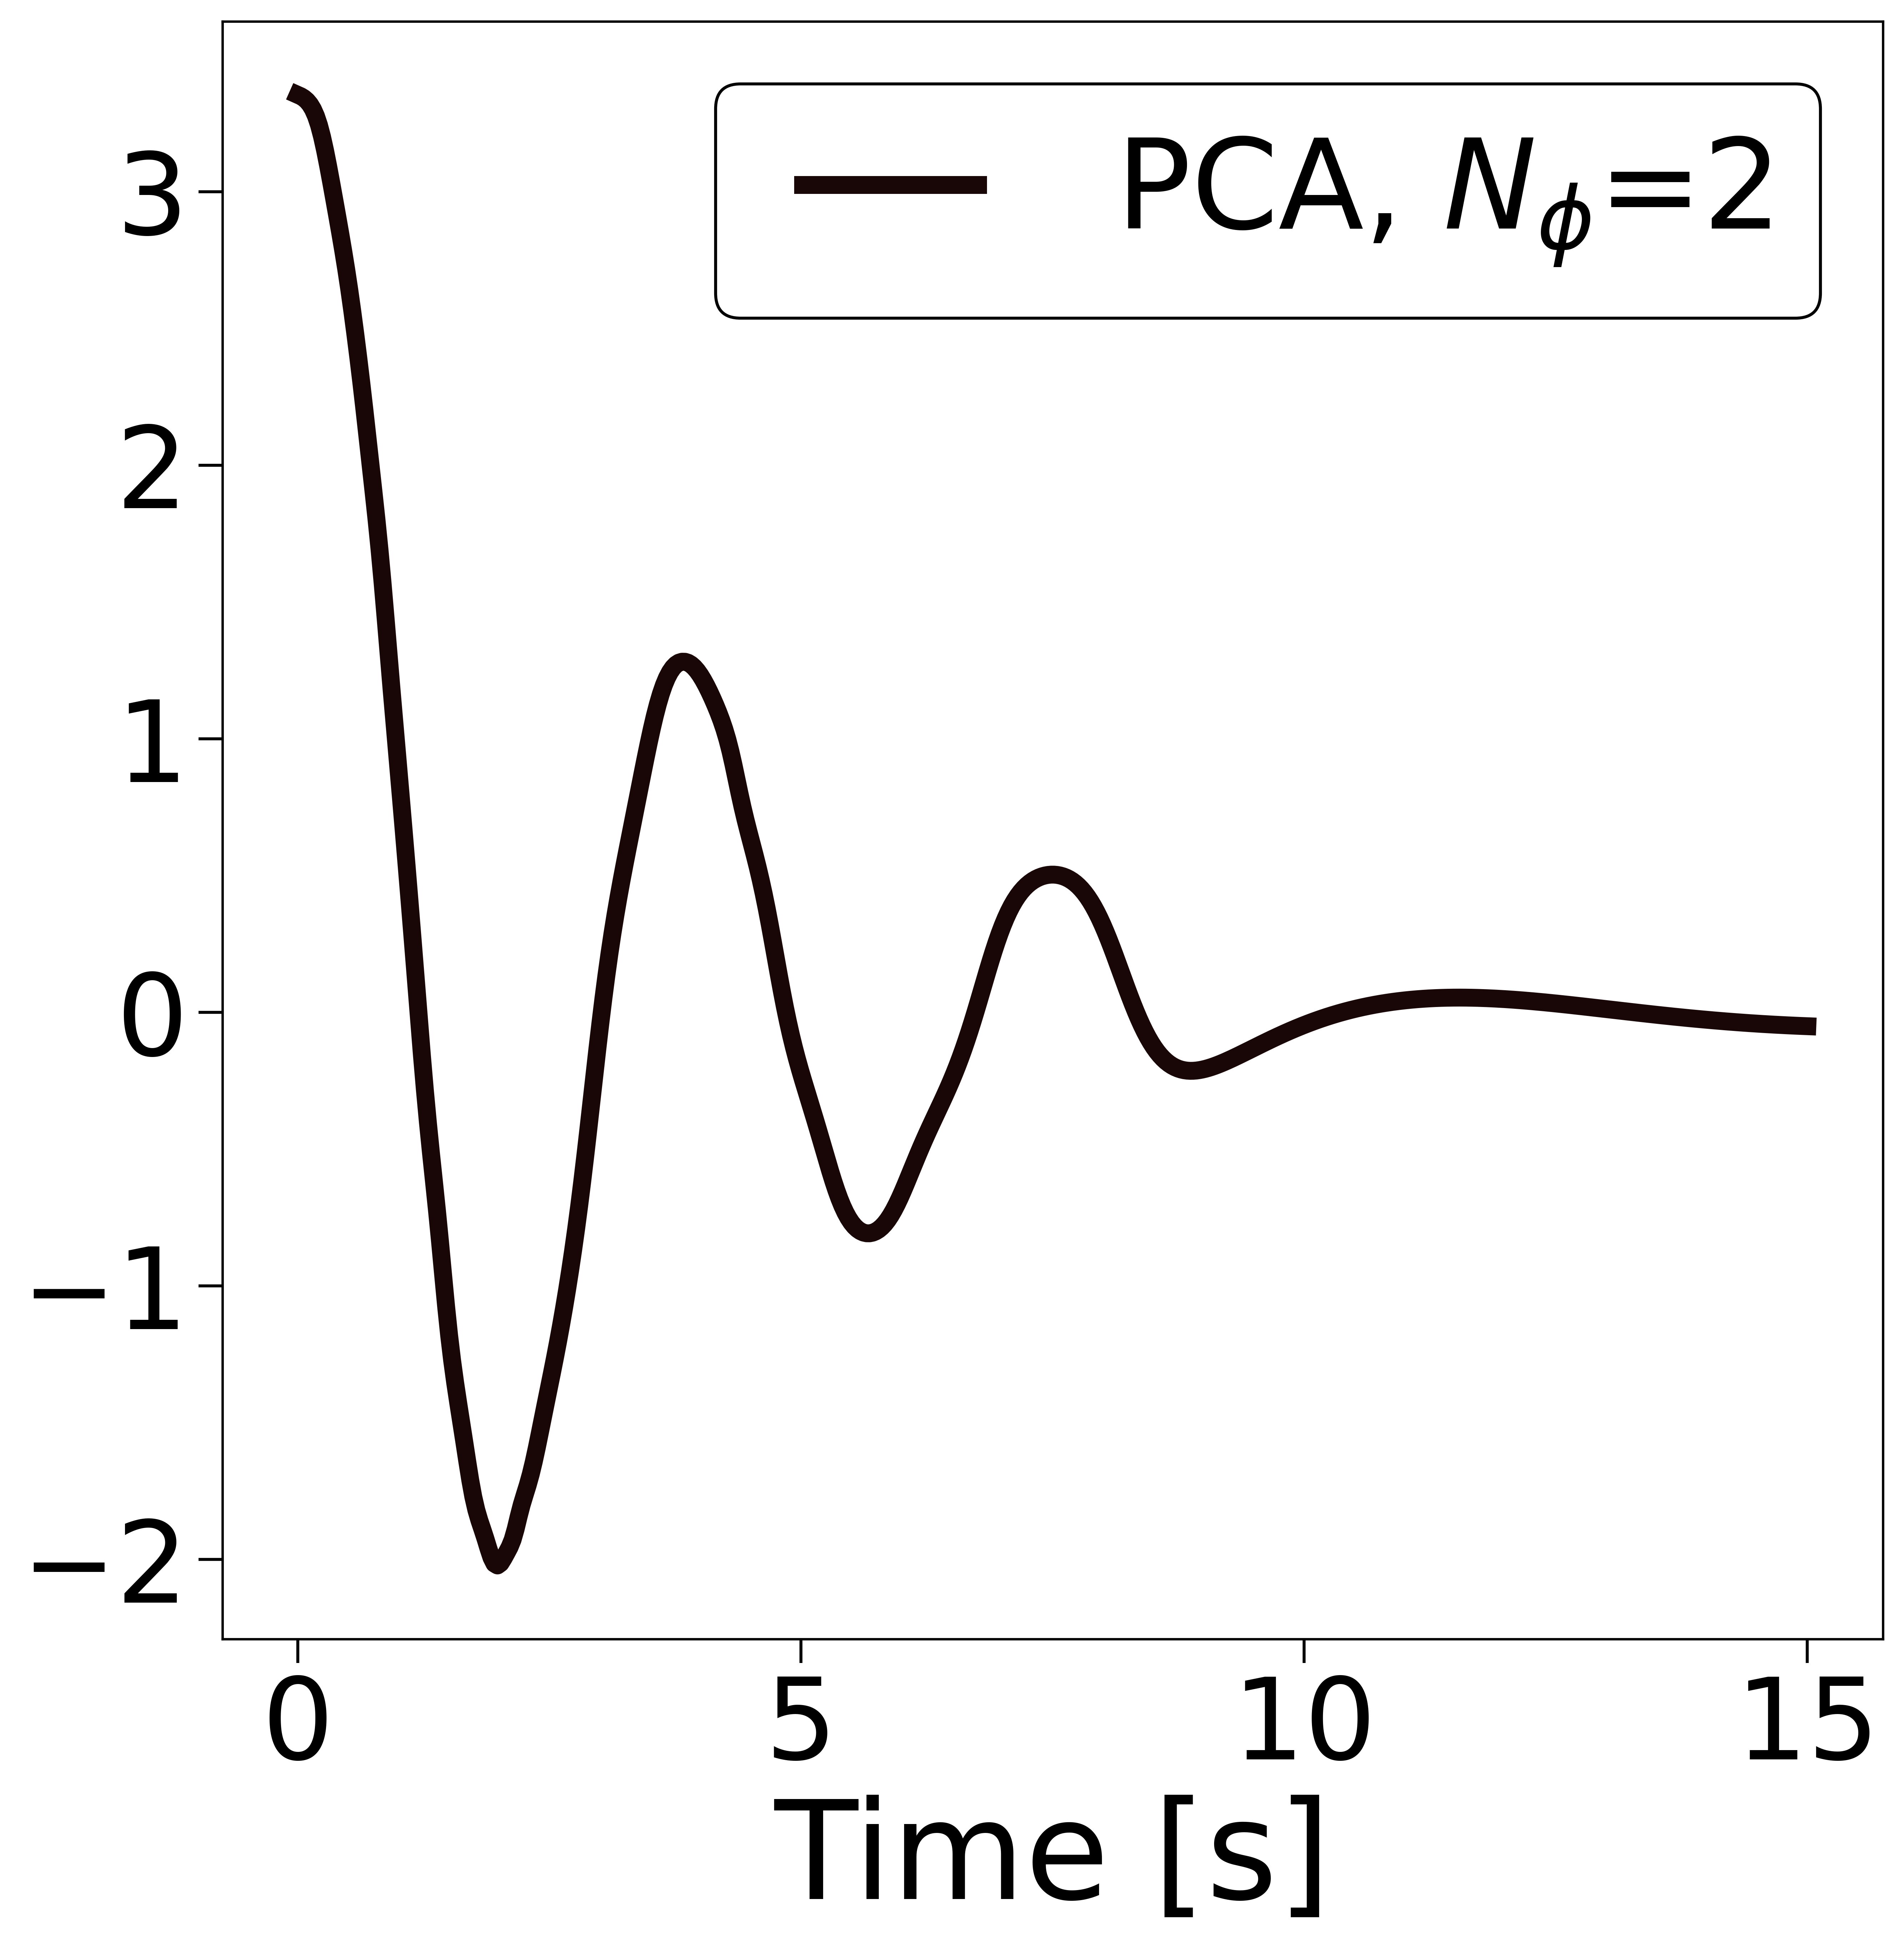

In [9]:
yMat_PCA_  = model.predict(tVec)    
yMat_      = (yMat_PCA_.dot(A))*D[:,0] + C[:,0]

iScenario    = 50
n_modesFinal = A.shape[0]

plt.figure()
#plt.plot(tVec, yMat[:,iScenario],  '-', label='ODE')
plt.plot(tVec, yMat_[:,iScenario], '-', label='PCA, $N_{\phi}$='+str(n_modesFinal))
plt.xlabel('Time [s]')
plt.ylabel('')
plt.legend()

## Writing Trunk's Parameter in the Fina.hdf5 File for Future DeepONet's Transfer/Generative Learning

In [10]:
import h5py
import tensorflow as tf
from keras    import backend
from keras    import __version__ as keras_version  # pylint: disable=g-import-not-at-top
from keras.saving import saving_utils


def _legacy_weights(layer):
    """DO NOT USE.
    For legacy reason, the layer.weights was in the order of
    [self.trainable_weights + self.non_trainable_weights], and this order was
    used for preserving the weights in h5 format. The new order of layer.weights
    are the same as layer.get_weights() which is more intuitive for user. To
    keep supporting the existing saved h5 file, this method should be used to
    save/load weights. In future version, we will delete this method and
    introduce a breaking change for h5 and stay with the new order for weights.
    Args:
    layer: a `tf.keras.Model` or `tf.keras.layers.Layer` instance.
    Returns:
    A list of variables with the order of trainable_weights, followed by
      non_trainable_weights.
    """
    weights = layer.trainable_weights + layer.non_trainable_weights
    if any(not isinstance(w, tf.Variable) for w in weights):
        raise NotImplementedError(
            f'Save or restore weights that is not an instance of `tf.Variable` is '
            f'not supported in h5, use `save_format=\'tf\'` instead. Received a '
            f'model or layer {layer.__class__.__name__} with weights {weights}')
    return weights



def save_attributes_to_hdf5_group(group, name, data):
    HDF5_OBJECT_HEADER_LIMIT = 64512
    
    bad_attributes = [x for x in data if len(x) > HDF5_OBJECT_HEADER_LIMIT]

    # Expecting this to never be true.
    if bad_attributes:
        raise RuntimeError('The following attributes cannot be saved to HDF5 '
                           'file because they are larger than %d bytes: %s' %
                           (HDF5_OBJECT_HEADER_LIMIT, ', '.join(bad_attributes)))

    data_npy = np.asarray(data)

    num_chunks = 1
    chunked_data = np.array_split(data_npy, num_chunks)

    # This will never loop forever thanks to the test above.
    while any(x.nbytes > HDF5_OBJECT_HEADER_LIMIT for x in chunked_data):
        num_chunks += 1
        chunked_data = np.array_split(data_npy, num_chunks)

    if num_chunks > 1:
        for chunk_id, chunk_data in enumerate(chunked_data):
            group.attrs['%s%d' % (name, chunk_id)] = chunk_data
    else:
        group.attrs[name] = data

        
def load_attributes_from_hdf5_group(group, name):
    """Loads attributes of the specified name from the HDF5 group.
    This method deals with an inherent problem
    of HDF5 file which is not able to store
    data larger than HDF5_OBJECT_HEADER_LIMIT bytes.
    Args:
      group: A pointer to a HDF5 group.
      name: A name of the attributes to load.
    Returns:
      data: Attributes data.
    """
    if name in group.attrs:
        data = [
            n.decode('utf8') if hasattr(n, 'decode') else n
            for n in group.attrs[name]
        ]
    else:
        data = []
        chunk_id = 0
        while '%s%d' % (name, chunk_id) in group.attrs:
            data.extend([
              n.decode('utf8') if hasattr(n, 'decode') else n
              for n in group.attrs['%s%d' % (name, chunk_id)]
          ])
        chunk_id += 1
    return data


def save_weights_to_hdf5_group(f, layers, old_string, new_string):

    layer_names_temp = load_attributes_from_hdf5_group(f_new, 'layer_names')
    layer_names_old  = []
    for layer in layer_names_temp:
        layer_names_old.append(layer.encode('utf8'))
    
    layer_names = []
    for layer in layers:
        if (old_string in layer.name):
            layer_name = layer.name.replace(old_string, new_string) #############
            layer_names.append(layer_name.encode('utf8'))
            layer._name = layer_name

    save_attributes_to_hdf5_group(f, 'layer_names', layer_names+layer_names_old)
    f.attrs['backend'] = backend.backend().encode('utf8')
    f.attrs['keras_version'] = str(keras_version).encode('utf8')

    # Sort model layers by layer name to ensure that group names are strictly
    # growing to avoid prefix issues.
    for layer in sorted(layers, key=lambda x: x.name):
        if (new_string in layer.name):
            layer_name    = layer.name.replace(old_string, new_string) ############# 
            g             = f.create_group(layer_name)
            weights       = _legacy_weights(layer)
            weight_values = backend.batch_get_value(weights)

            weight_names = []
            for w in weights:
                w_name = w.name.replace(old_string, new_string) ############# 
                weight_names.append(w_name.encode('utf8'))
            #weight_names = [w.name.encode('utf8') for w in weights]
            save_attributes_to_hdf5_group(g, 'weight_names', weight_names)
            for name, val in zip(weight_names, weight_values):
                param_dset = g.create_dataset(name, val.shape, dtype=val.dtype)
                if not val.shape:
                    # scalar
                    param_dset[()] = val
                else:
                    param_dset[:] = val

In [11]:
try:
    os.makedirs(InputData.path_to_data_fld+'/../../FNN/')
except:
    pass
filename_new = InputData.path_to_data_fld+'/../../FNN/Final.h5'

f_new        = h5py.File(filename_new, 'a')

if (PCAType == 'All'):
    save_weights_to_hdf5_group(f_new, NN.layers, 'FNN-FNN', 'DeepONet-Trunk')
else:
    save_weights_to_hdf5_group(f_new, NN.layers, 'FNN-FNN', 'DeepONet-Trunk_'+str(i_red))
    
f_new.close()

ValueError: Unable to create group (name already exists)

In [ ]:
# f_new        = h5py.File(filename_new, 'a')

# data = load_attributes_from_hdf5_group(f_new, 'layer_names')
# data

# f_new.close()

In [ ]:
f_new.close()